In [1]:
# this mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

FOLDERNAME = 'Dental AI Project'

import sys
PATH = f'/content/drive/My Drive/{FOLDERNAME}'
sys.path.append(PATH)

%cd $PATH

Mounted at /content/drive
/content/drive/My Drive/Dental AI Project


In [2]:
# Math/deep learning libraries
import numpy as np
import torch

# set random seed here!
torch.manual_seed(420)
from torch import nn

# Data processing
import pandas as pd

# Data transformations
import torchvision
import torch.nn.functional as F

# Loading images/bundles of images
from PIL import Image
import h5py

# Plotting
import matplotlib.pyplot as plt

# Progress bars
from tqdm import tqdm

# Other
import time
from datetime import date

In [3]:
# Set PyTorch to use the GPU, if possible
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


## Load Dataset

In [4]:
import torchvision.transforms as T

class TongueDataset(torch.utils.data.Dataset):
    def __init__(self, csv_path, data_path, device=device):
        self.images = []
        self.labels = []
        self.classes = []
        self._label_dict = dict()
        self._num_classes = 0
        self.transform = T.ToTensor()

        csv = pd.read_csv(csv_path)
        prev_class = ""
        for i in tqdm(range(len(csv))):
            file_path = csv.iloc[i]['filepath']
            img = Image.open(f'./{data_path}/{file_path}')
            imgTensor = self.transform(img).to(device=device)
            self.images.append(img)
            self.labels.append(csv.iloc[i]['label'])
            self.classes.append(csv.iloc[i]['class'])
            if self.classes[i] != prev_class:
                prev_class = self.classes[i]
                self._num_classes += 1
                self._label_dict[self.labels[i]] = self.classes[i]
        
        assert len(self.images) == len(self.labels)
    
    def __len__(self):
        """Returns the number of examples in the dataset"""
        return len(self.images)
    
    def num_classes(self):
        """Returns the number of classes in the dataset"""
        return self._num_classes
    
    def get_class(self, label):
        """Returns the name of the bird corresponding to the given label value"""
        return self._label_dict[label]

    def get_image(self, idx):
        """Returns the image of the idx'th example in the dataset"""
        return self.images[idx]

    def get_label(self, idx):
        """Returns the label of the idx'th example in the dataset"""
        return self.labels[idx]
    
    def __getitem__(self, idx):
        """Returns a tuple of the *transformed* image and label of the idx'th example in the dataset"""
        return (self.transform(self.images[idx]), self.labels[idx])
    
    def display(self, idx):
        """Displays the image at a given index"""
        display(T.ToPILImage()(self.get_image(idx)))

In [5]:
# takes anywhere between 3 and 13 minutes
all_data = TongueDataset("filelabels.csv", "Combined")

100%|██████████| 1078/1078 [03:43<00:00,  4.82it/s]


## Define AI

In [6]:
from torchvision.models import resnet50

class TongueAI(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        # input = 224 x 224 x 3
        self.resnet = resnet50(weights=None) #pre-trained weights
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.resnet(x)

In [7]:
aug = T.Compose([
    T.RandomResizedCrop(size=(224, 224)) # uses default scale and ratio values used by ImageNet
])

eval_aug = T.Compose([
    T.RandomCrop((224, 224), pad_if_needed=True) # no stretching/scaling
])

In [8]:
train_len = 755
val_len = 323
batch_size = 32

train_set, val_set = torch.utils.data.random_split(all_data, [train_len, val_len])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=1, shuffle=False)

In [9]:
# split is a variable you can set as the "name" of the dataset (either "train" or "val")
def evaluate(model, data_loader, name="val"):
    model.eval()
    correct = 0  # number of correct predictions
    total = 0    # total number of examples in the data loader

    with torch.no_grad():
        for images, labels in data_loader:
            outputs = model(eval_aug(images).to(device=device))
            _, predicted = torch.max(outputs.data, 1)
            predicted = predicted.cpu()   # Move to cpu so it can be compared with labels, which is on cpu
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on the {total} {name} images: {100 * correct / total}%')

def train_model(model, start, end):
    start_time = time.time()
    for epoch in range(start, end):
        model.train() #turns on dropout
        epoch_loss = 0
        for batch_idx, (images, labels) in enumerate(train_loader):
            images = aug(images).to(device=device)
            labels = labels.to(device=device) # Put the labels on GPU as well
            optimizer.zero_grad()
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() / labels.shape[0]
        print(f"Epoch {epoch}/{end}")
        evaluate(model, train_loader, name="train")
        evaluate(model, val_loader, name="test")

    end_time = time.time()
    print(f"Total training time: {end_time - start_time} sec")

# Train AI

In [52]:
model = TongueAI().to(device=device)

In [65]:
learning_rate = 5e-5
num_epochs = 10

In [66]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0) # weight_decay is L2 regularization

In [68]:
train_model(model, 0, 10)

Epoch 0/10
Accuracy of the network on the 755 train images: 73.50993377483444%
Accuracy of the network on the 323 test images: 66.25386996904025%
Epoch 1/10
Accuracy of the network on the 755 train images: 73.64238410596026%
Accuracy of the network on the 323 test images: 70.58823529411765%
Epoch 2/10
Accuracy of the network on the 755 train images: 73.64238410596026%
Accuracy of the network on the 323 test images: 69.6594427244582%
Epoch 3/10
Accuracy of the network on the 755 train images: 72.98013245033113%
Accuracy of the network on the 323 test images: 69.96904024767802%
Epoch 4/10
Accuracy of the network on the 755 train images: 72.71523178807946%
Accuracy of the network on the 323 test images: 69.96904024767802%
Epoch 5/10
Accuracy of the network on the 755 train images: 72.98013245033113%
Accuracy of the network on the 323 test images: 69.96904024767802%
Epoch 6/10
Accuracy of the network on the 755 train images: 72.58278145695364%
Accuracy of the network on the 323 test images

# Save Model

In [70]:
#torch.save(model.state_dict(), "./Models/resnet_72.pt")

# Note: it was named resnet_72 because its accuracy on the test images during the training phase reached a peak of 72%.

# Load Model

In [10]:
resnet72 = TongueAI().to(device=device)
resnet72.load_state_dict(torch.load("./Models/resnet_72.pt"))
resnet72.eval()

TongueAI(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          

# Evaluate Model

In [15]:
def eval_one_image(model, idx):
    image, label = all_data.__getitem__(idx)
    image = image.unsqueeze(0) # make it a batch of size 1
    outputs = model(eval_aug(image).to(device=device))
    _, predicted = torch.max(outputs.data, 1)
    predicted = predicted.cpu()
    display(all_data.get_image(idx))
    print(f'Predicted: {all_data.get_class(predicted.item())}')
    print(f'Actual: {all_data.get_class(label)}')

def eval_all_images(model, val_loader):
    matrix = [[0 for i in range(4)] for j in range(4)]
    for (images, labels) in val_loader:
        images = images.to(device=device)
        output = model(eval_aug(images))
        _, predicted = torch.max(output.data, 1)
        predicted = predicted.item()
        labels = labels.item()
        matrix[predicted][labels] += 1

    return matrix

In [16]:
torch.manual_seed(84)
matrix = eval_all_images(resnet72, val_loader)
print(matrix)

[[119, 34, 4, 4], [1, 0, 0, 0], [3, 2, 46, 17], [6, 2, 37, 48]]


# Plot Confusion Matrix

In [4]:
matrix = [[119, 34, 4, 4], [1, 0, 0, 0], [3, 2, 46, 17], [6, 2, 37, 48]]
classes = ['cancer', 'precancer', 'normal', 'benign']

In [3]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
df = pd.DataFrame(matrix, index = classes, columns = classes)

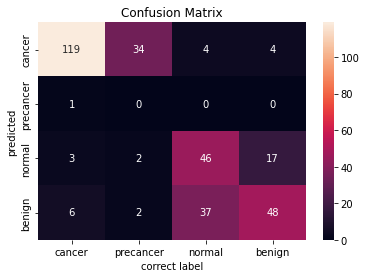

In [9]:
plt.figure()
sn.heatmap(df, annot=True, fmt='d')
plt.xlabel('correct label')
plt.ylabel('predicted')
plt.title('Confusion Matrix')
plt.show()

In [13]:
grouped_matrix = [[119+34+1, 4+4], [3+2+6+2, 46+17+37+48]]
grouped_classes = ["pre/cancer", "normal/benign"]
df2 = pd.DataFrame(grouped_matrix, index=grouped_classes, columns=grouped_classes)

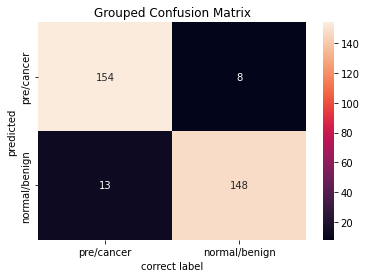

In [19]:
plt.figure()
sn.heatmap(df2, annot=True, fmt='d')
plt.xlabel('correct label')
plt.ylabel('predicted')
plt.title('Grouped Confusion Matrix')
plt.show()

In [16]:
def accuracy(matrix):
    return sum([matrix[i][i] for i in range(len(matrix))])/sum([sum(matrix[i]) for i in range(len(matrix))])

In [20]:
print("raw accuracy with 4 classes:")
accuracy(matrix)

raw accuracy with 4 classes:


0.6594427244582043

In [21]:
print("accuracy with grouped classes:")
accuracy(grouped_matrix)

accuracy with grouped classes:


0.934984520123839